# Project Machine Learning: Group 25
### Peter Bonnarens, Lennert Franssens & Philip Kukoba

# Sprint 1 : Tabular Data

### Possible tasks:
* Thorough exploratory data analysis, e.g.:
    * Are there substantial price differences between neighbourhoods ?
    * Are there hosts with more than one listing ? How does this impact the price ?
    * What is the correlation between the review score and the price ?
    * ...

    Not enough to just show a plot! Clearly describe WHAT question you investigated, WHY you think this is a relevant question
    and WHAT you deduce/conclude from the results of your data analysis

* Are there outliers ?
* A new Airbnb owner needs to pick an appropriate price:
    * Train a model to predict the price based on a selection of features
    * Find the most similar listings
    
* ...

# Table of work (who did what)

<br>

## Exploratory Data Analysis (EDA)
|                   	| EDA step 1 	| EDA step 2A 	| EDA step 2B 	| EDA step 2C 	| EDA step 2D 	| EDA step 3A 	| EDA step 3B 	| EDA step 3C 	| EDA step 3D 	| EDA step 3E 	| EDA step 3F 	|
|:-----------------:	|:----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|
|  Peter Bonnarens  	|      X     	|             	|      X      	|             	|             	|             	|             	|      X       	|            	|      X      	|      X      	|
| Lennert Franssens 	|      X     	|      X      	|      X      	|             	|      X      	|      X       	|      X       	|      X       	|      X       	|      X       	|      X       	|
|   Philip Kukoba   	|      X     	|             	|             	|      X      	|             	|             	|             	|            	|            	|            	|            	|

<br>

## Linear Regression Model (LR)
|                   	| LR step 1 	| LR step 2 	| LR step 3 	| LR step 4 	|
|:-----------------:	|:---------:	|:---------:	|:---------:	|:---------:	|
|  Peter Bonnarens  	|      X     	|           	|           	|       X     	|
| Lennert Franssens 	|      X     	|           	|           	|       X     	|
|   Philip Kukoba   	|           	|           	|           	|           	|

<br>

# Exploratory Data Analysis (EDA)

## Step 1: imports & loading the dataset
In this step we import the needed libraries and read the dataset into a pandas dataframe.

In [1998]:
%matplotlib inline

# imports
import numpy as np
import matplotlib.pyplot as plt

import regex as re

import pandas as pd  
import seaborn as sns 
from matplotlib import rcParams

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KDTree
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings

# delete warnings from output
warnings.filterwarnings('ignore')

# figure size in inches
plt.rcParams['figure.figsize'] = 15, 12

# loading the dataset into pandas dataframe
listings = pd.read_csv("data/listings.csv")

## Step 2: preprocessing

Before we can start our EDA, we need to preprocess our data. This means changing string values to integers, removing NaN values, removing garbage data...
Let us first take a look at our dataset. 

In [1999]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Unnamed: 74
0,187870,https://www.airbnb.com/rooms/187870,20210716195504,2021-07-16,Luxury studio 'Spiegelhof' in the centre of Ghent,The top floor of our house in the center of Gh...,We live in a quiet and pleasant neighborhood w...,https://a0.muscache.com/pictures/26c46224-795c...,904277,https://www.airbnb.com/users/show/904277,Tamara,2011-08-01,"Ghent, Flanders, Belgium",We are living in a house in the center of beau...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/a9437...,https://a0.muscache.com/im/pictures/user/a9437...,NaN,2.0,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Ghent, Flemish Region, Belgium",Watersportbaan - Ekkergem,NaN,51.05168,3.70283,Private room in condominium,Private room,2,NaN,1.5 baths,1,1.0,"[""Microwave"", ""Keypad"", ""Extra pillows and bla...",$65.00,2,90,2,2,1125,1125,2.0,1125.0,NaN,t,2,24,54,326,2021-07-16,419,25,1,2012-01-03,2021-05-23,4.85,4.90,4.95,4.90,4.87,4.58,4.85,NaN,t,1,0,1,0,3.61,NaN
1,203806,https://www.airbnb.com/rooms/203806,20210716195504,2021-07-16,Flat close to Sint-Pieters Station!,This well-located and comfortable one-bedroom ...,The house is located in a dead-end street - so...,https://a0.muscache.com/pictures/fe477b7f-93ac...,999847,https://www.airbnb.com/users/show/999847,Lies,2011-08-21,PA,I am a legal advisor who always worked interna...,within an hour,100%,88%,t,https://a0.muscache.com/im/users/999847/profil...,https://a0.muscache.com/im/users/999847/profil...,NaN,3.0,3,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Ghent, Flemish Region, Belgium",Watersportbaan - Ekkergem,NaN,51.04428,3.71395,Entire apartment,Entire home/apt,2,NaN,1 bath,1,2.0,"[""Dishwasher"", ""Ethernet connection"", ""Microwa...",$79.00,2,1125,1,2,1125,1125,1.7,1125.0,NaN,t,1,17,18,276,2021-07-16,287,2,1,2013-03-31,2019-05-07,4.59,4.72,4.73,4.80,4.79,4.49,4.54,NaN,f,2,2,0,0,2.84,NaN
2,204245,https://www.airbnb.com/rooms/204245,20210716195504,2021-07-16,Modern studio's in Ghent centre,<b>The space</b><br />We offer luxury studio's...,NaN,https://a0.muscache.com/pictures/1766072/02965...,1003009,https://www.airbnb.com/users/show/1003009,Nele,2011-08-22,"Gent, Vlaams Gewest, Belgium",I want to welcome foreign guests in the city c...,within a day,100%,100%,f,https://a0.muscache.com/im/users/1003009/profi...,https://a0.muscache.com/im/users/1003009/profi...,NaN,2.0,2,"['email', 'phone', 'reviews']",t,f,NaN,Binnenstad,NaN,51.05842,3.72721,Entire apartment,Entire home/apt,2,NaN,1 bath,1,1.0,"[""Shampoo"", ""Wifi"", ""TV"", ""Heating"", ""Dedicate...",$93.00,1,14,1,2,14,14,1.3,14.0,NaN,t,20,47,77,124,2021-07-16,30,1,0,2013-01-04,2018-10-24,4.79,4.73,4.93,4.83,4.70,4.97,4.6

In [2000]:
print(listings.shape)

(923, 75)


Notice that the dataset contains a lot of text values that are not needed for this sprint, and that we start with 923 rows of data and 75 features. The first step is to make a selection of the features we think can be useful or can give us insights.

### 2A : Feature subset selection

Here is a list of the features that we think could possibly be useful during this sprint:
* **id**: (int64) unique identifier for the listing
* **host_id**: (object) unique identifier for the host
* **host_response_time**: (object) description of how long it usually takes the host to respond
* **host_response_rate**: (object) the % rate at which the host responds
* **host_acceptance_rate**: (object) the % rate at which the host accepts booking requests
* **host_total_listings_count**: (int64) The number of listings the host has
* **host_verifications**: (object) array containing the different types of verification methods the host supports
* **host_has_profile_pic**: (object) boolean value that indicates if the host has a profile picture or not
* **host_identity_verified**: (object) boolean value that indicates wether the host is verified or not
* **neighbourhood_cleansed**: (object) the neighbourhood as geocoded using the latitude and longitude
* **latitude**: (object) latitude of listing
* **longitude**: (object) longitude of listing
* **room_type**: (object) room type
* **accomodates**: (object) maximum capacity of the listing
* **bedrooms**: (object) number of bedrooms in the listing
* **beds**: (float64) number of beds
* **price**: (object) daily price in local currency
* **minimum_nights**: (object) minimum number of night stay for the listing
* **maximum_nights**: (int64) maximum number of night stay for the listing
* **number_of_reviews**: (object) the number of reviews the listing has
* **number_of_reviews_ltm**: (int64) the number of reviews the listing has (in the last 12 months)
* **last_review**: (object) the date of the last/newest review
* **review_scores_rating**: (object) overall rating of the listing
* **instant_bookable**: (object) boolean value that indicates wwhether the guest can automatically book the listing without the host requiring to accept their booking request
* **reviews_per_month**: (float64) the number of reviews the listing has over the lifetime of the listing

We noticed that some rows in the dataset contained data that was shifted 1 column to the right starting from the 'host_since' column. Instead of removing these rows from the dataset, we decided to shift these rows 1 column back to the left.

In [2001]:
# find lines to shift and add them to a mask - we've found that some lines are shifted 1 to the right beginning on the host_id column (that now contains garbage data)
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_since':'reviews_per_month'] = listings.loc[mask, 'host_since':'reviews_per_month'].shift(-1, axis=1)

Some of these features do not have the types we expect them to be. This is due to the fact that there are still NaN/garbage values in the dataset. Some columns also nead to be cast to the correct type. We can check the types of the columns like this:

In [2002]:
# prepare extra columns to split number of bathrooms per type
listings['priv_bath'] = listings['bathrooms_text']
listings['bathrooms'] = listings['bathrooms_text']

# filter columns

listings = listings[["id", "host_id", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_total_listings_count", 
    "host_verifications", "host_identity_verified", "neighbourhood_cleansed", "latitude", "longitude", "property_type", "room_type",
    "accommodates", "priv_bath", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights","availability_90",
    "number_of_reviews", "number_of_reviews_ltm", "last_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
    "review_scores_location", "review_scores_value", "instant_bookable", "reviews_per_month"]]

In [2003]:
print(listings.dtypes.to_string())

id                               int64
host_id                         object
host_response_time              object
host_response_rate              object
host_acceptance_rate            object
host_is_superhost               object
host_total_listings_count       object
host_verifications              object
host_identity_verified          object
neighbourhood_cleansed          object
latitude                       float64
longitude                       object
property_type                   object
room_type                       object
accommodates                    object
priv_bath                       object
bathrooms                       object
bedrooms                        object
beds                            object
price                           object
minimum_nights                  object
maximum_nights                   int64
availability_90                  int64
number_of_reviews               object
number_of_reviews_ltm            int64
last_review              

### 2B : cleaning the data
Now all of the data are in the right columns, we can clean the individual records.
First we drop the rows where NaN values are present. These rows are considered as corrupt rows that contain invalid or too few data to work with.
After dropping these rows, we can convert rows with numeric data saved as strings to numeric types.

Some other rows still contains textual data that can easily be transformed to numeric data.


In [2004]:
# clean property types
listings['property_type'] = ['Room'    if re.match('.*room.*', x, re.IGNORECASE) 
                                            else 'House' if re.match('.*house.*', x, re.IGNORECASE) 
                                            else 'Apartment' if re.match('.*apartment.*', x, re.IGNORECASE) 
                                            else 'Other'
                                            for x in listings["property_type"]]

# convert percentage to float
listings["host_response_rate"] = listings['host_response_rate'].str.rstrip('%').astype('float') / 100.0
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

# convert to number of verification types
listings['host_verifications'] = listings['host_verifications'].apply(eval).apply(lambda x: len(x))

# convert booleans: 1 if true, 0 if false
listings["host_identity_verified"] = listings["host_identity_verified"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)
listings["instant_bookable"] = listings["instant_bookable"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)
listings["host_is_superhost"] = listings["host_is_superhost"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)

# private bathroom and shared bathroom
listings['bathrooms'] = listings['bathrooms'].replace('\s.*', '', regex=True)
listings['bathrooms'] = listings['bathrooms'].replace('^[a-zA-Z].*', '0.5', regex=True)
listings['priv_bath'] = listings['priv_bath'].replace('.*ared.*', '0', regex=True)
listings['priv_bath'] = listings['priv_bath'].replace('.*[a-zA-Z].*', '1', regex=True)

listings['bathrooms'] = listings['bathrooms'].astype(float)
listings['priv_bath'] = listings['priv_bath'].astype(float)

# convert currency to float
listings['price'] = listings['price'].replace('[\$,)]', '', regex=True).astype(float)

In [2005]:
# first we drop the rows that contain missing values
listings.dropna(inplace=True)

# next we convert some columns to numeric values
listings[["accommodates", "bedrooms", "minimum_nights", "number_of_reviews", "review_scores_rating", "longitude", "beds", "host_id", "host_total_listings_count", "maximum_nights", "number_of_reviews_ltm"]] = listings[["accommodates","bedrooms", "minimum_nights", "number_of_reviews", "review_scores_rating", "longitude","beds", "host_id", "host_total_listings_count", "maximum_nights", "number_of_reviews_ltm"]].apply(pd.to_numeric)

## Step 3 : plots

### 3A: Histograms of most interesting numeric features

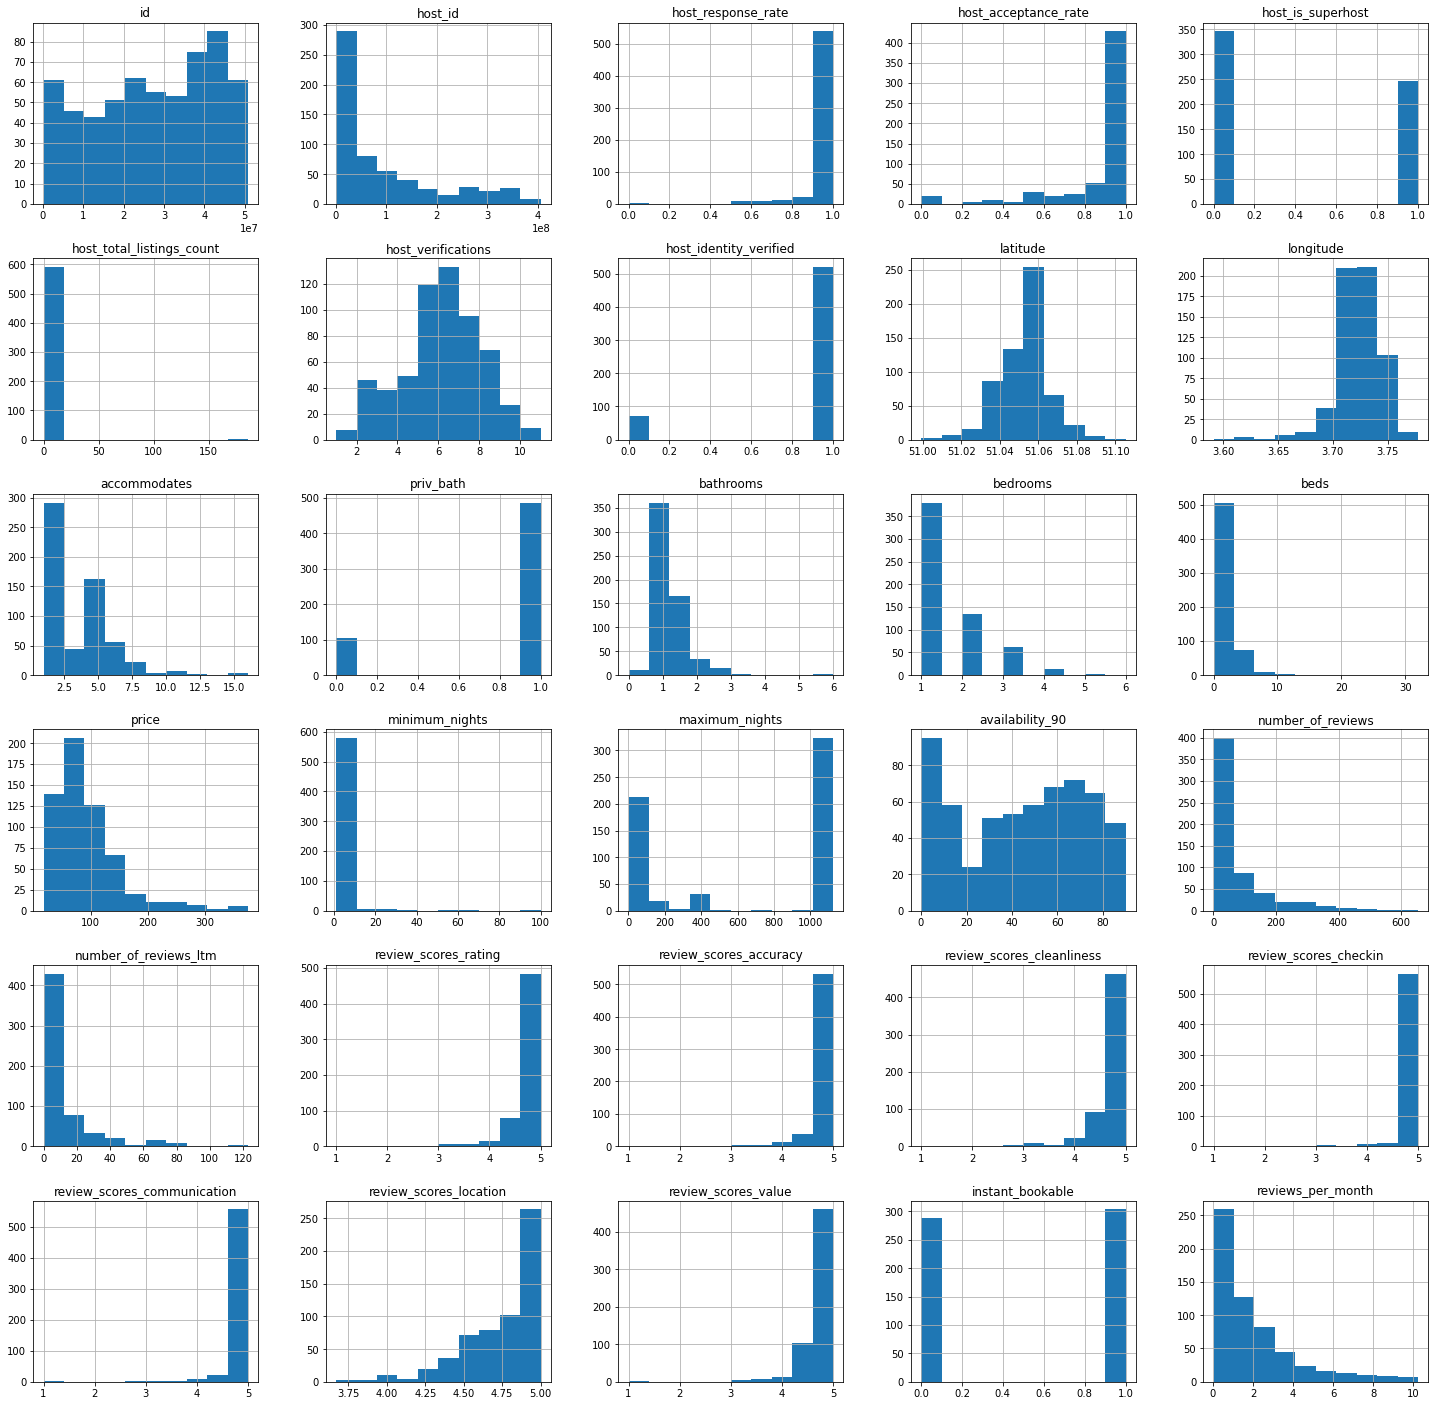

In [2006]:
listings.hist(figsize=(25,25));

### 3B: Distribution and pairplot
The first graph shows the distribution of the prices.
The second graph shows scatterplots. There we can find out if there are good predictors for our target price.

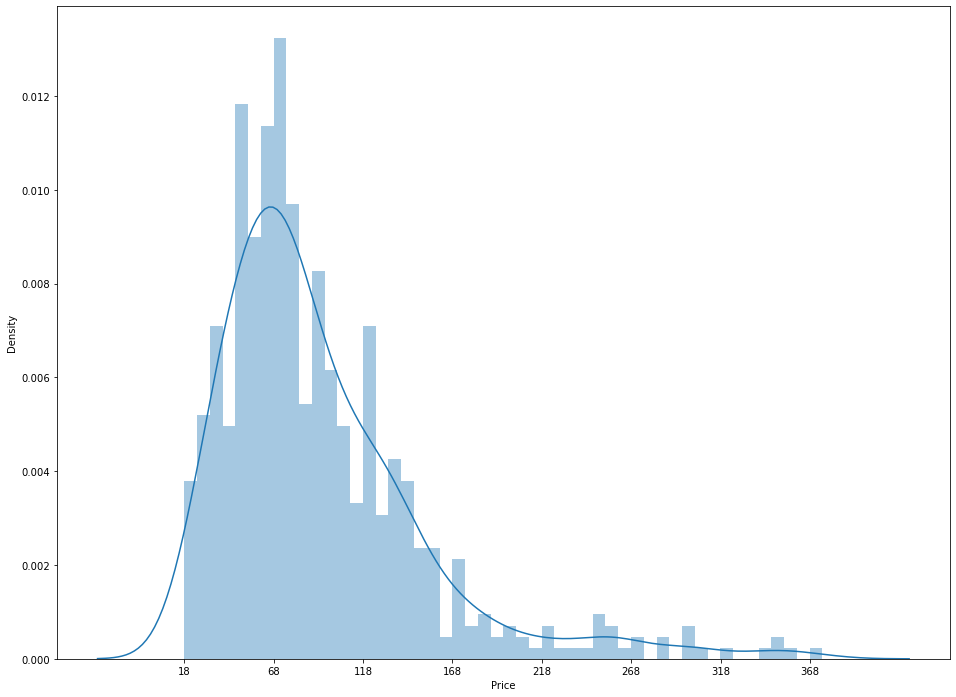

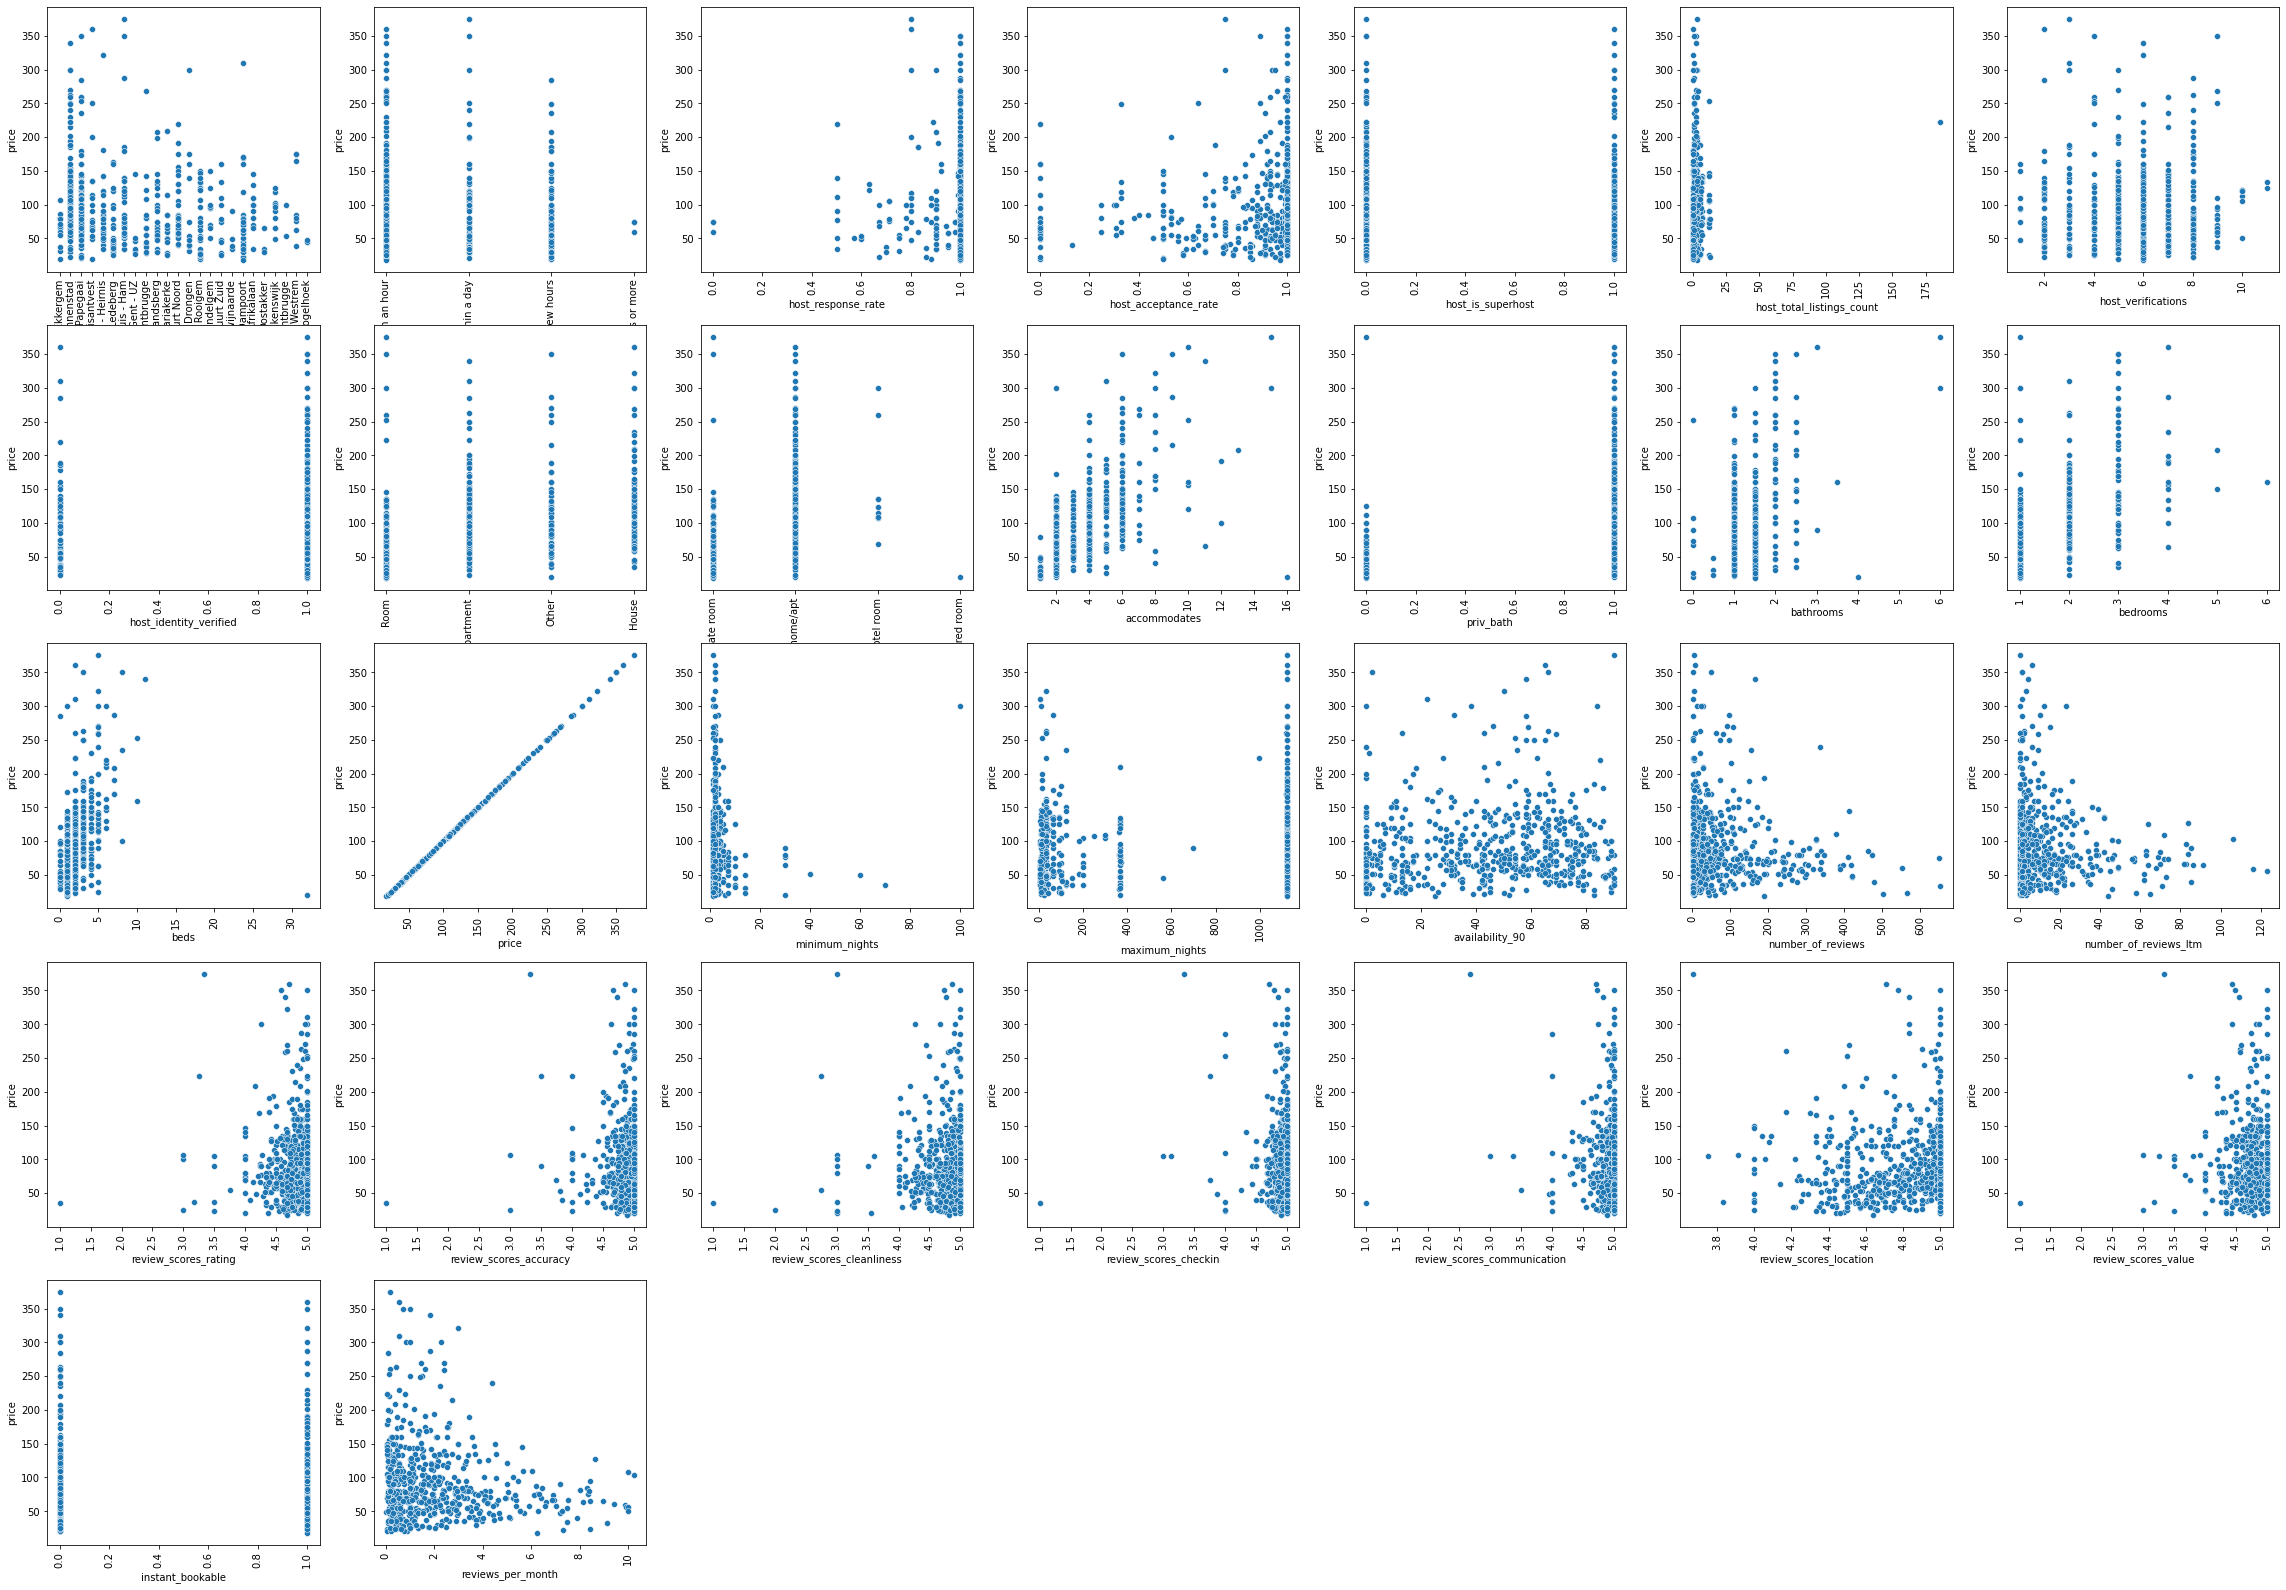

In [2007]:
plt.figure(figsize=(16,12))
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

dataset = listings[["neighbourhood_cleansed", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_total_listings_count", 
    "host_verifications", "host_identity_verified", "property_type","room_type",
    "accommodates", "priv_bath", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights", "availability_90",
    "number_of_reviews", "number_of_reviews_ltm", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
    "review_scores_location", "review_scores_value", "instant_bookable", "reviews_per_month"]]
sns.distplot(dataset.price, bins=50)
plt.xlabel("Price")
plt.xticks(np.arange(min(dataset.price.to_numpy()), max(dataset.price.to_numpy()), 50.0))
plt.show()

#sns.pairplot(dataset, vars=["host_response_time", "host_response_rate", "host_acceptance_rate", "host_total_listings_count", "host_verifications", "host_identity_verified", "accommodates", "bedrooms", "beds", "number_of_reviews", "number_of_reviews_ltm", "review_scores_rating", "instant_bookable", "reviews_per_month", "room_type", "rt_Entire home/apt", "rt_Hotel room", "rt_Private room", "rt_Shared room"])

plt.figure(figsize=(40,40))
for i, k in enumerate(dataset.keys()):
    plt.subplot(7,7,1+i)
    plt.xticks(rotation=90)
    sns.scatterplot(x=dataset[k], y=dataset["price"])


### 3C: Boxplots
Some boxplots to gain more insight about the used price range per accommodate, room type and neighbourhood.

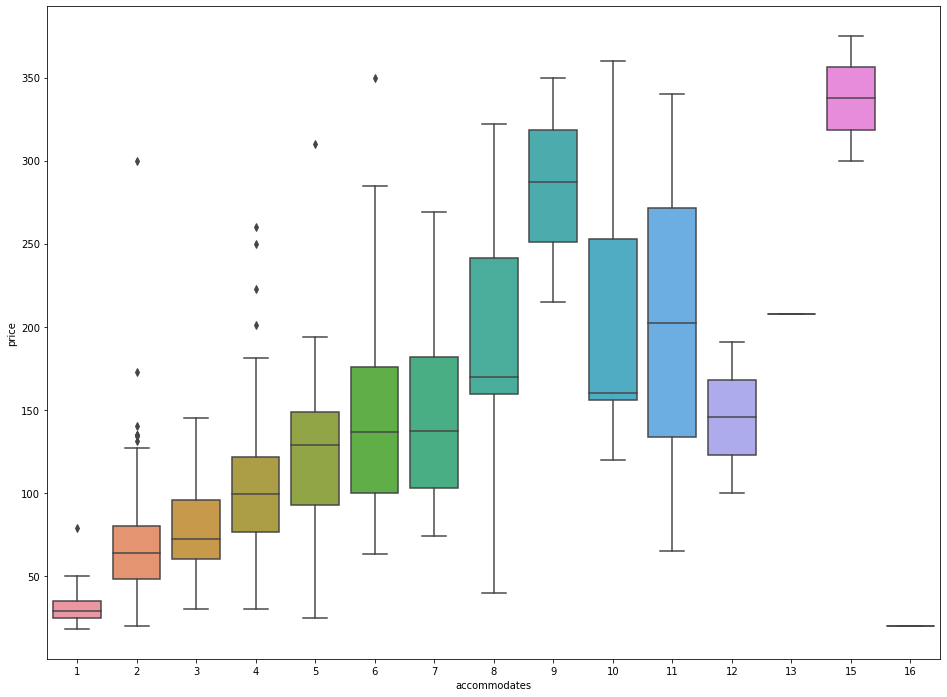

In [2008]:
plt.figure(figsize=(16,12))
sns.boxplot(x="accommodates", y="price", data=dataset);

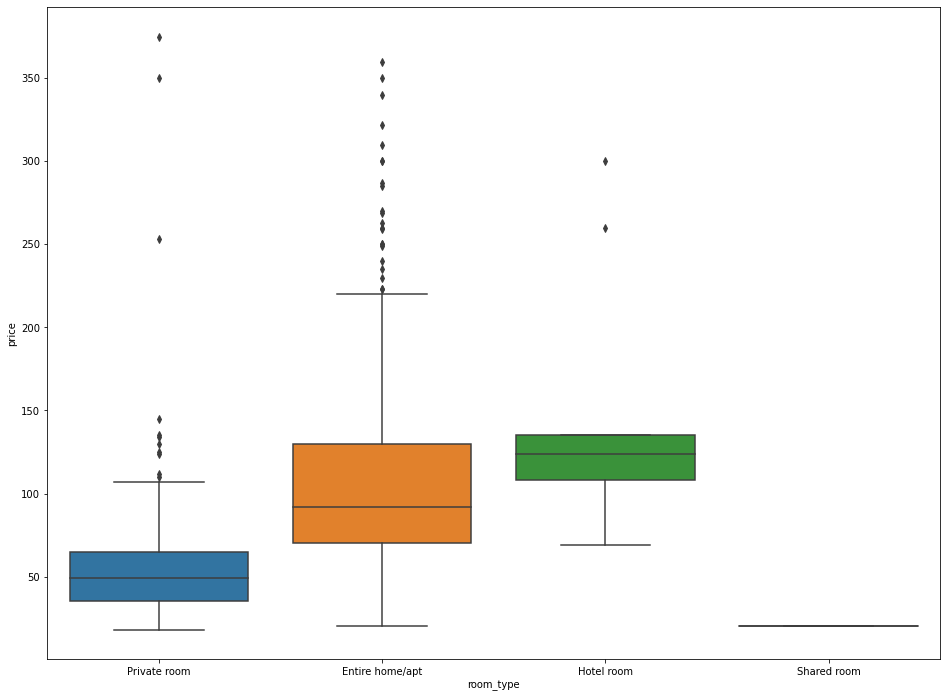

In [2009]:
plt.figure(figsize=(16,12))
sns.boxplot(x=dataset.room_type, y=dataset.price);

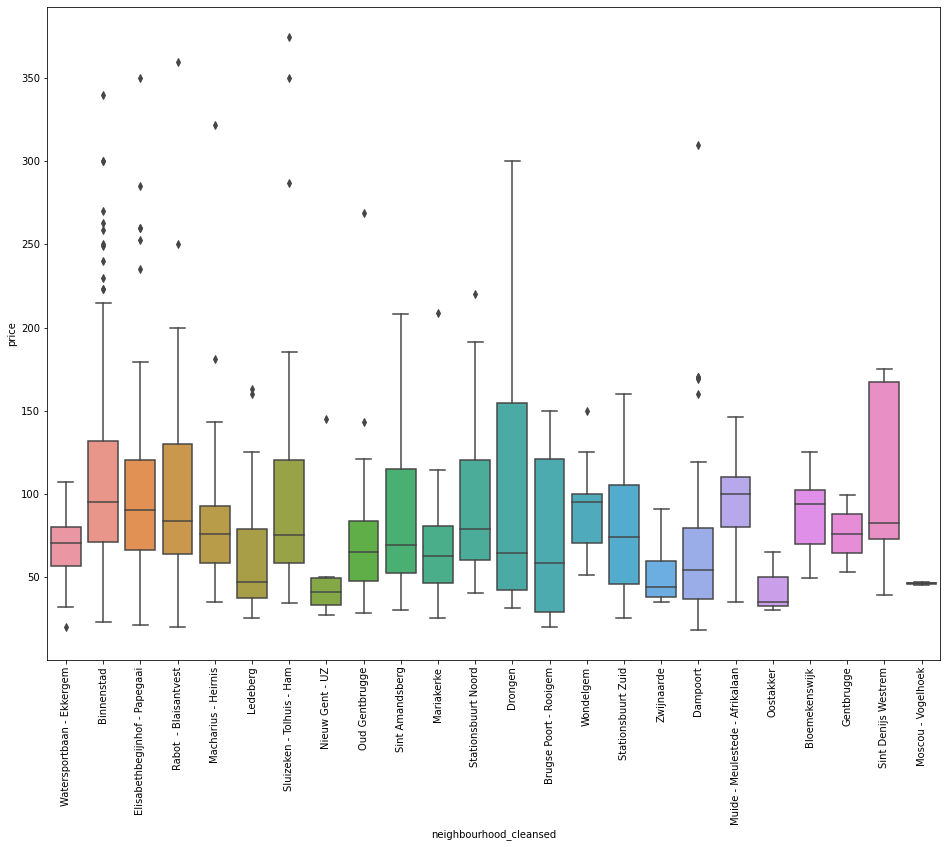

In [2010]:
plt.figure(figsize=(16,12))
plt.xticks(rotation=90)
sns.boxplot(x=dataset.neighbourhood_cleansed, y=dataset.price);

Impact on the price if host has more than one listing

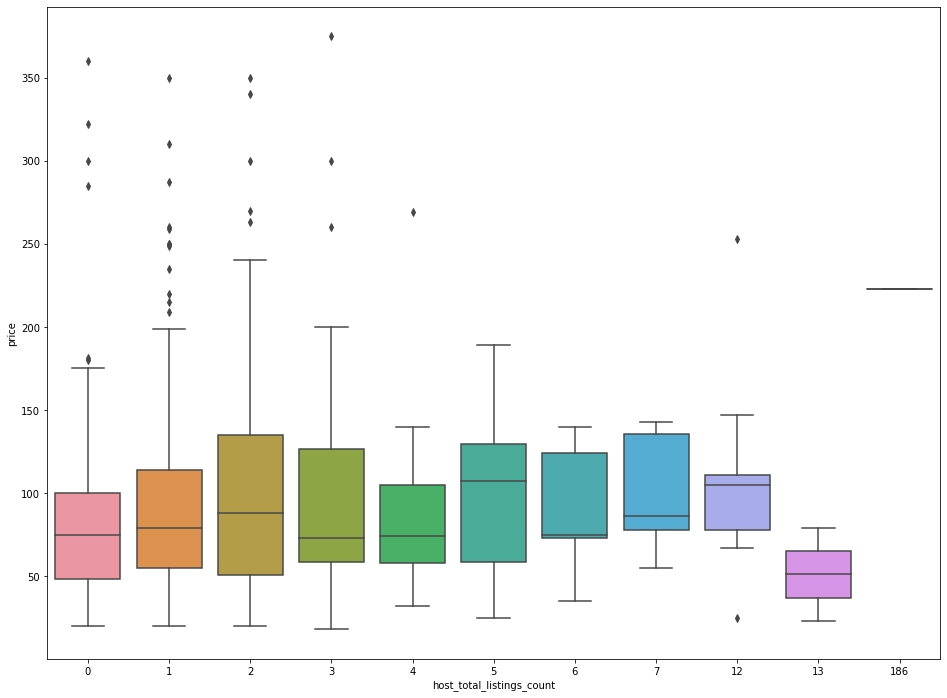

In [2011]:
plt.figure(figsize=(16,12))
sns.boxplot(x=dataset.host_total_listings_count, y=dataset.price);

Correlation between review score and price

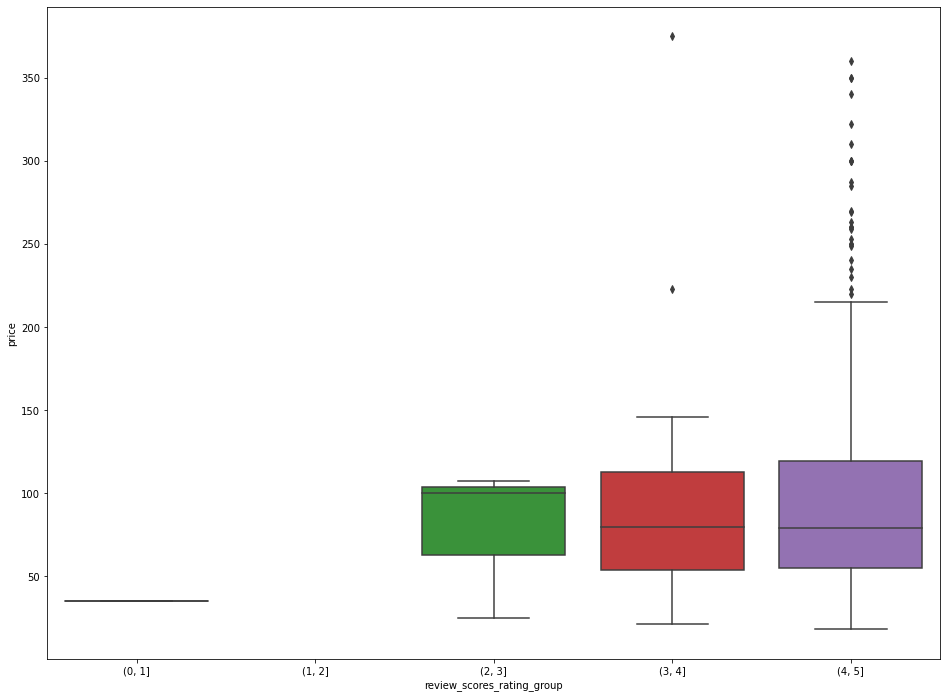

In [2012]:
plt.figure(figsize=(16,12))
dataset['review_scores_rating_group'] = pd.cut(dataset['review_scores_rating'], bins=range(0, 6, 1))
sns.boxplot(x=dataset.review_scores_rating_group, y=dataset.price)
dataset.drop(['review_scores_rating_group'], inplace=True, axis=1)

Correlation between review score and number of reviews

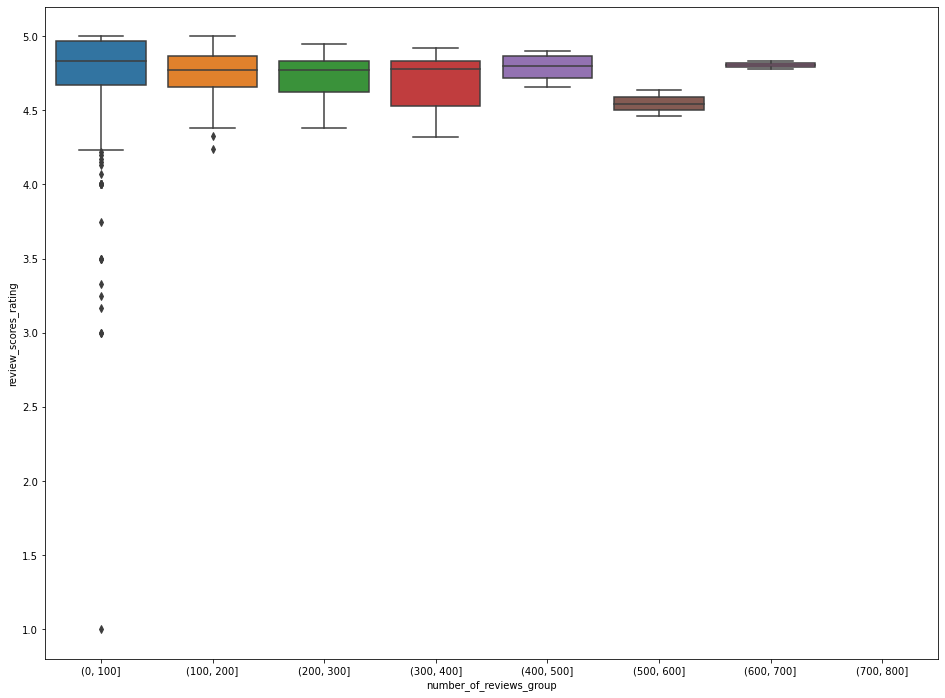

In [2013]:
plt.figure(figsize=(16,12))
dataset['number_of_reviews_group'] = pd.cut(dataset['number_of_reviews'], bins=range(0, 900, 100))
sns.boxplot(x=dataset.number_of_reviews_group, y=dataset.review_scores_rating)
dataset.drop(['number_of_reviews_group'], inplace=True, axis=1)

### 3D: Histograms

Number of listings per number of accommodates, bathrooms, bedrooms and beds

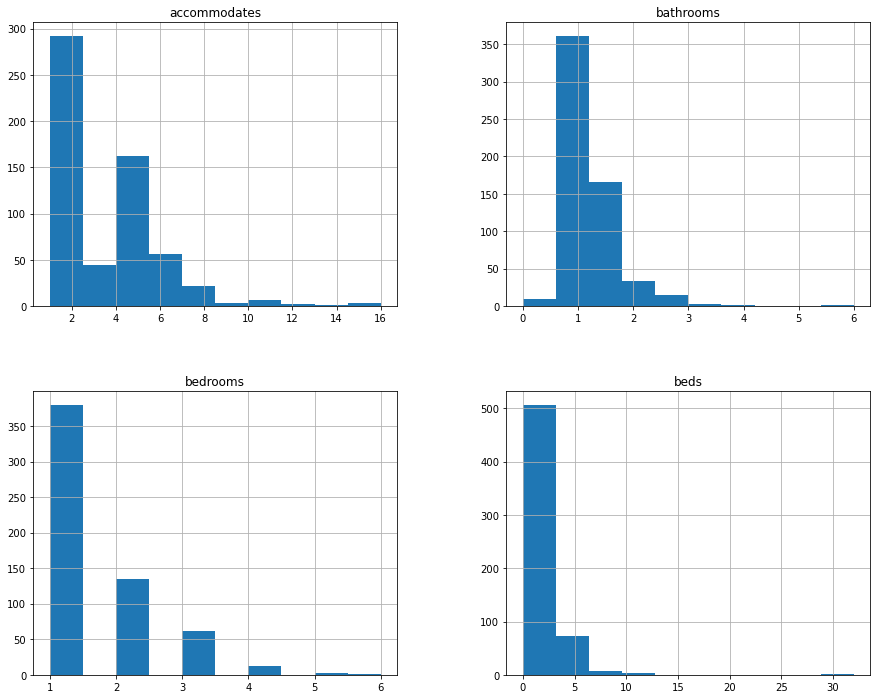

In [2014]:
dataset[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist();

Distribution of property and room type

Entire home/apt    0.687500
Private room       0.295608
Hotel room         0.015203
Shared room        0.001689
Name: room_type, dtype: float64

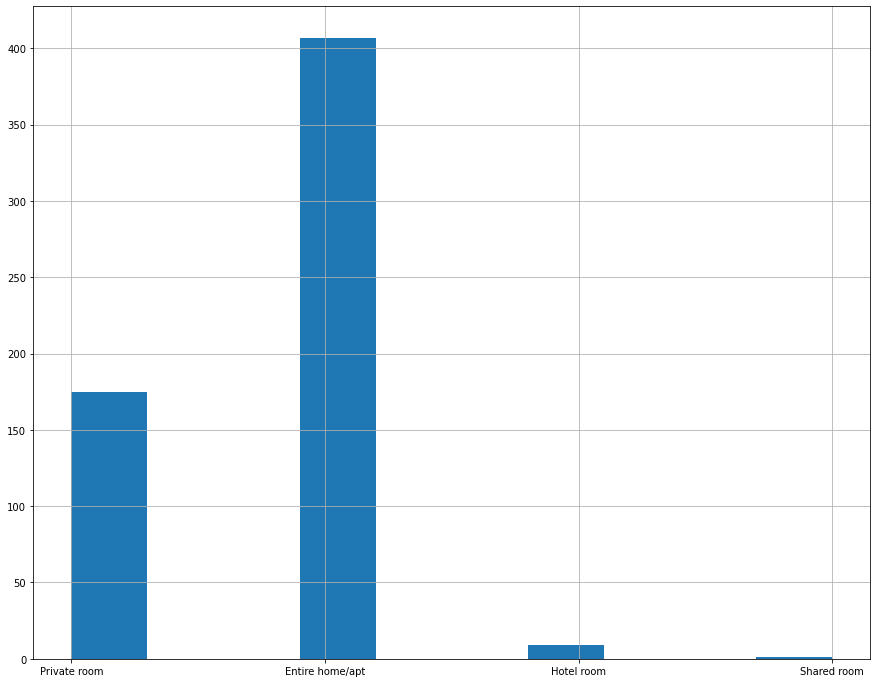

In [2015]:
dataset['room_type'].hist()
dataset['room_type'].value_counts(normalize=True)

Apartment    0.371622
Room         0.314189
House        0.185811
Other        0.128378
Name: property_type, dtype: float64

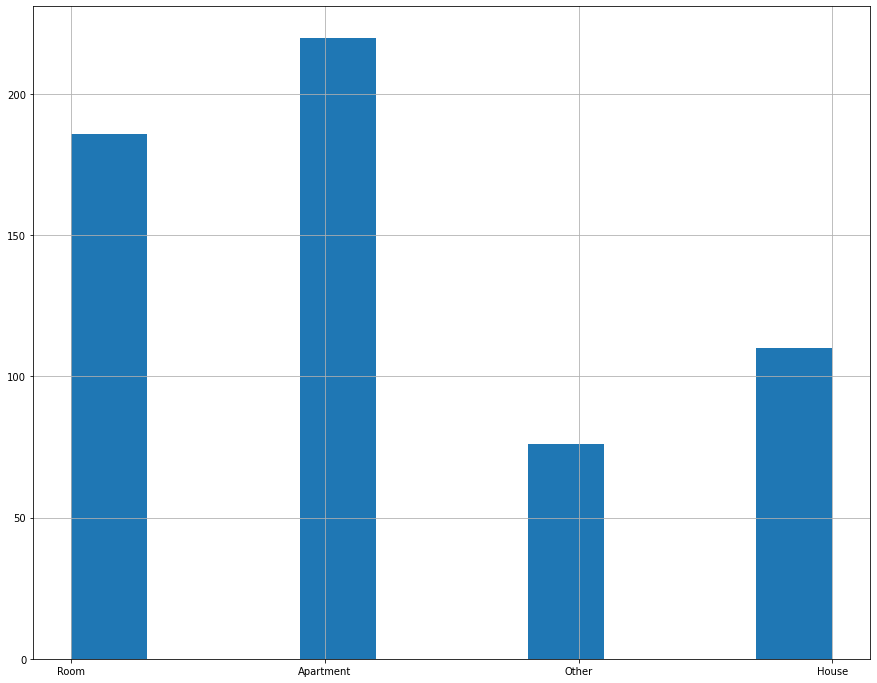

In [2016]:
dataset['property_type'].hist()
dataset['property_type'].value_counts(normalize=True)

### 3E: One-hot encodings and correlation matrix
We do a one-hot encoding for categorical features. After that we can plot a correlation matrix.

In [2017]:
# Replace categorical features with one-hot encodings
a = pd.get_dummies(listings['host_response_time'], prefix = "hrt")
b = pd.get_dummies(listings['room_type'], prefix = "rt")
c = pd.get_dummies(listings['property_type'], prefix = "pt")
frames = [listings, a, b, c]
listings = pd.concat(frames, axis = 1)

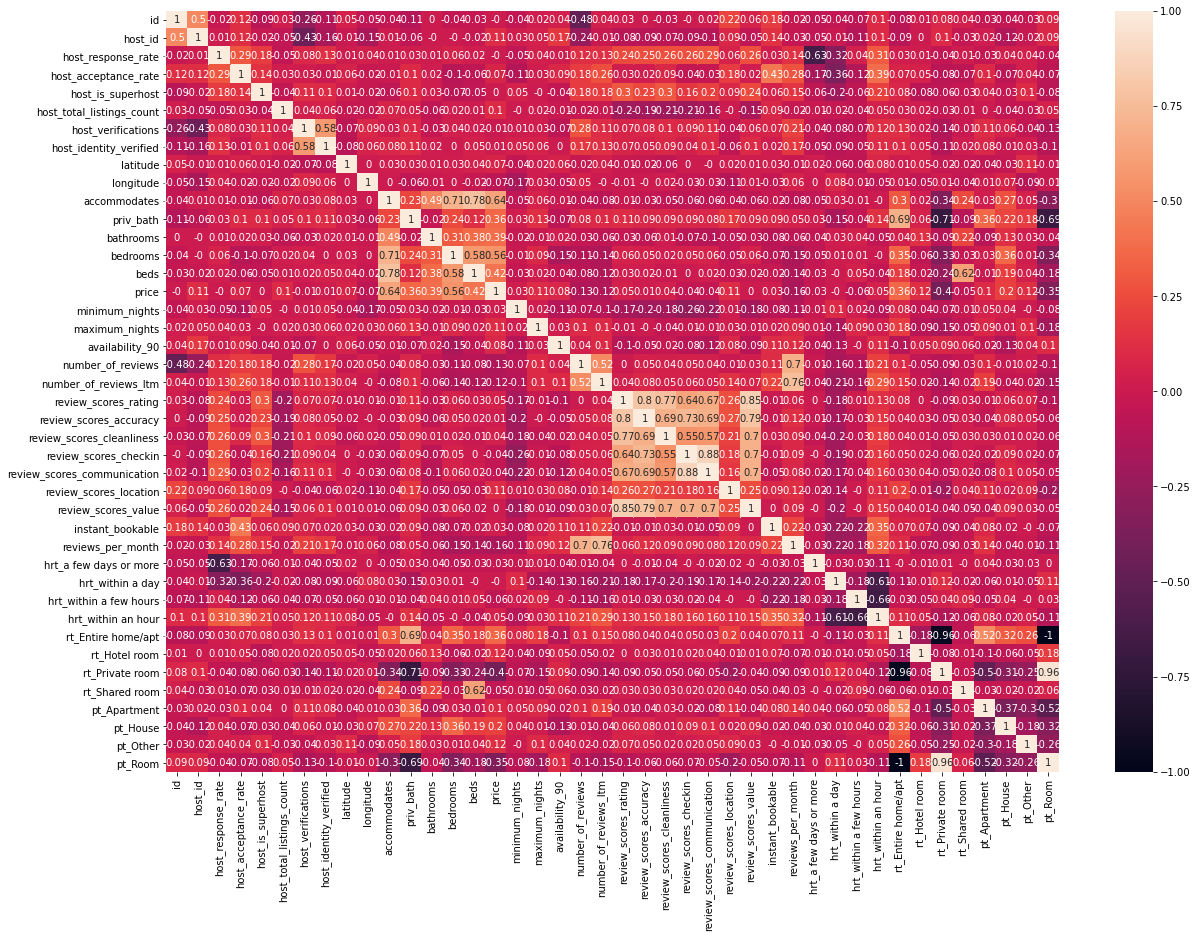

In [2018]:
correlation_matrix = listings.corr().round(2)
plt.figure(figsize=(20,14))
sns.heatmap(data=correlation_matrix, annot=True);

### 3F: Log transformation of columns that could benefit from it
We can see that there are some features that could benefit from a log transformation. This can be concluded from the histograms from 3A.

After the transformation we can see that there are some features that are normally distributed.

In [2019]:
tfo_listings = listings[["host_total_listings_count", "accommodates", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights", "number_of_reviews"]]

for col in tfo_listings.keys():
    tfo_listings[col] = tfo_listings[col].astype('float64').replace(0.0, 0.01)
    tfo_listings[col] = np.log(tfo_listings[col])

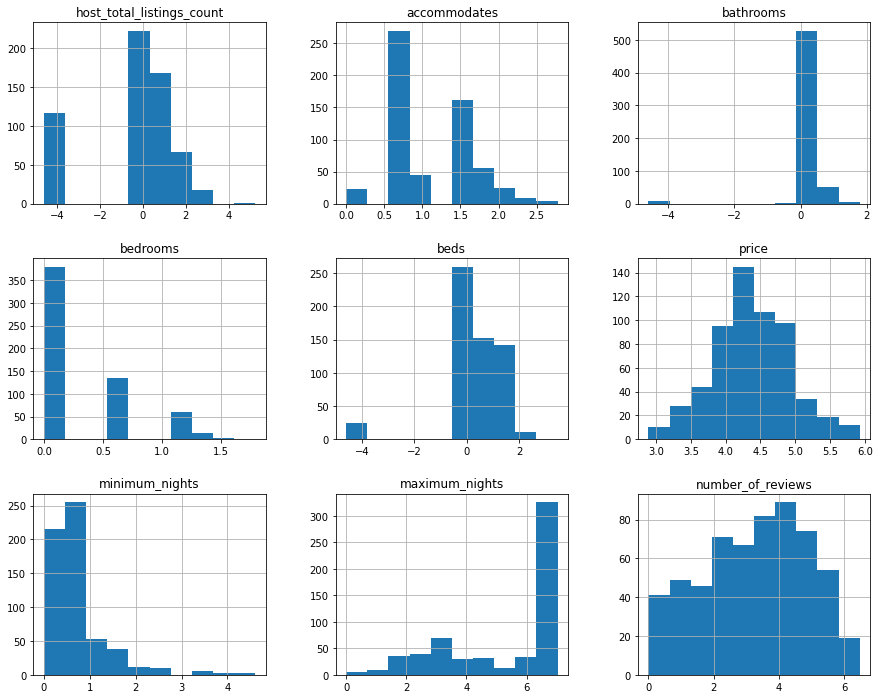

In [2020]:
tfo_listings.hist();

Now we can drop some colums that are not needed anymore.

In [2021]:
dataset.drop(['neighbourhood_cleansed'], inplace=True, axis=1)
dataset.drop(['room_type'], inplace=True, axis=1)
dataset.drop(['property_type'], inplace=True, axis=1)
dataset.drop(['host_response_time'], inplace=True, axis=1)

# Linear Regression Model

## Step 1 : Train - Test - Split

In [2022]:
x = tfo_listings.drop(['price'], axis=1) # pd.concat((), axis=1)
y = tfo_listings['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

## Step 2: Normalizing the data

In [2023]:
# TODO
# formule: x-xmin/xmax-xmin

## Step 3 : Training the model

In [2024]:
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

y_train_predict = lin_model.predict(x_train)
y_test_predict = lin_model.predict(x_test)

## Step 4 : Measure the performance of the model

In [2025]:
# model evaluation for training set
n_train = len(x_train)  # sample size
p_train = len(x_train.columns)  # number of independent variables
R2_train = r2_score(y_train, y_train_predict)
RMSE_train = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
# use the adjusted R² score to counter accidental increase of score with number of input features.
adj_R2_train = 1 - ((1-R2_train) * (n_train-1)/(n_train-p_train-1))   #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

print("Model train performance")
print("--------------------------------------")
print('RMSE is {}'.format(RMSE_train))
print('R2 score is {}'.format(R2_train))
print('adjusted R2 score is {}'.format(adj_R2_train))
print("\n")

# model evaluation for testing set
n_test = len(x_test)
p_test = len(x_test.columns)
R2_test = r2_score(y_test, y_test_predict)
RMSE_test = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
adj_R2_test = 1 - ((1-R2_test) * (n_test-1)/(n_test-p_test-1))   #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

print("Model test performance")
print("--------------------------------------")
print('RMSE is {}'.format(RMSE_test))
print('R2 score is {}'.format(R2_test))
print('adjusted R2 score is {}'.format(adj_R2_test))
print("\n")


print("Model parameters")
print("--------------------------------------")
print(lin_model.coef_)
print(lin_model.intercept_)

Model train performance
--------------------------------------
RMSE is 0.41843094056420327
R2 score is 0.4646272160984606
adjusted R2 score is 0.4553966508587789


Model test performance
--------------------------------------
RMSE is 0.3827896272061771
R2 score is 0.48372163043971617
adjusted R2 score is 0.4461741126535137


Model parameters
--------------------------------------
[ 0.01873626  0.58602692  0.05219544  0.20502773 -0.01629695 -0.04537263
  0.02378806 -0.03376683]
3.6864059088153858


Compare the predicted values with the actual output.

In [2026]:
y_test_array = np.array(list(y_test))
y_test_predict_array = np.array(y_test_predict)
compare_table = pd.DataFrame({'Truth': y_test_array.flatten(), 'Predicted': y_test_predict_array.flatten()})
compare_table

,Truth,Predicted
0,3.806662,3.625395
1,3.637586,4.076292
2,4.787492,4.743358
3,4.290459,4.061847
4,4.174387,4.180900
...,...,...
114,4.382027,4.123302
115,4.304065,4.921690
116,4.553877,4.520012
117,4.543295,4.094840


# Random Forest Regression

## Step 1: Setup

In [2027]:
# change figsize here
plt.rcParams['figure.figsize'] = 8, 6

# helper functions
def run_predictions(tree, x):
    predictions = []
    for index, sample in x.iterrows():
        prediction = tree.predict(sample)
        predictions.append(prediction)
    return predictions
    
def visualize_results(predictions, ground_truth):
    
    plt.scatter(ground_truth, predictions, alpha=0.5)
    plt.xlabel("Ground truth price")
    plt.ylabel("Predicted price")
    plt.show()
    
    rmse = (np.sqrt(mean_squared_error(ground_truth, predictions)))
    r2 = r2_score(ground_truth, predictions)
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))

## Step 2: Split dataset

In [2028]:
#Split dataset in training and test set 
#TODO choose features more wisely

ds_copy = tfo_listings #dataset[["price", "host_response_time", "host_total_listings_count", "host_verifications", "host_identity_verified", "accommodates", "bathrooms", "bedrooms", "beds", "minimum_nights", "maximum_nights", "instant_bookable"]]
X = ds_copy.drop(['price'], axis=1)
Y = ds_copy["price"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

## Step 3: Run random forest regression

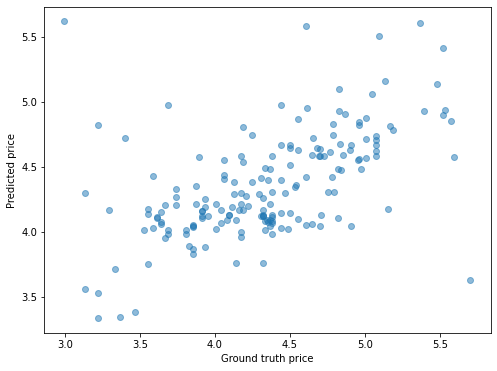

RMSE is 0.48146645257168935
R2 score is 0.2690208787867895


In [2029]:
regr = RandomForestRegressor(max_depth=8, random_state=0)
regr.fit(X_train, Y_train)

predictions = regr.predict(X_test)

visualize_results(predictions, Y_test)

It is clear from the RMSE and R2 measurements that the random forest regression does not deliver the best result. But we see the right shape of y=x with some noise.